In [ ]:
import copy
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch
from documentation import plot_predictions
from torch.utils.tensorboard import SummaryWriter

from data import artificial_1D_linear as data
from models.DenseNetwork import DenseNetwork
from utils.self_learning_network import SelfLearningNet, combine

torch.manual_seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
def get_logging_dir(name: str):
    return f"../../logs/artificial_1D_linear/{name}/{time.strftime('%m-%d-%H-%M-%S', time.localtime())}"

## Evaluating different learning algorithms on artifical 1D Dataset

Important Hyperparameters are set in the following:

In [84]:
BATCH_SIZE = 64

INPUT_FEATURES = 1
OUTPUT_FEATURES = 1
ARCHITECTURE = [12, 12, 12, 12]

The training data gets split into a 20/80 test/training split randomly. The data is visualized in the following plot:

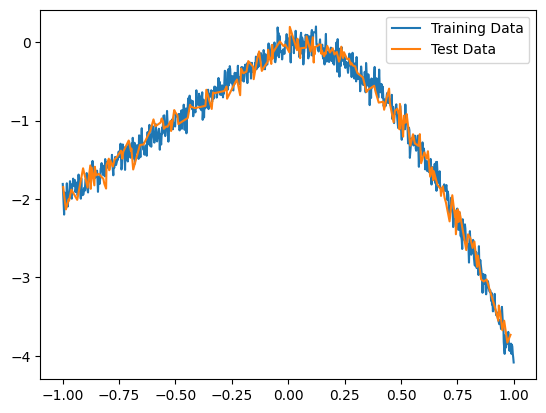

In [85]:
plt.plot(*data.get_data("train"), label="Training Data")
plt.plot(*data.get_data("test"), label="Test Data")
plt.legend()

In [86]:
# TODO: Add evaluation metrics

metrics = pd.DataFrame(columns=["Model", "MSE"])
loss_fn = torch.nn.MSELoss()


def evaluate(name: str, model, log):
    model.eval()
    test_dataloader = data.get_dataloader("test")
    for x, y in test_dataloader:
        y_hat = model(x)
        loss = loss_fn(y_hat, y).item()
        log(loss)
        metrics.add({"Model": name, "MSE": loss})

### 1. Standard Batch-Gradient Descent

In [87]:
train_dataloader = data.get_dataloader("train", BATCH_SIZE, shuffle=True)

EPOCHS = 100

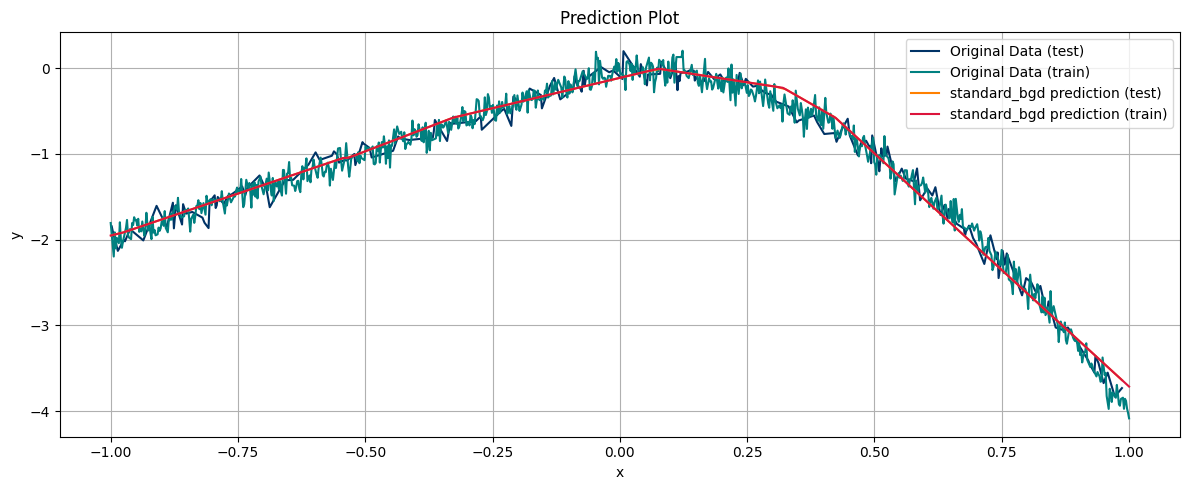

In [88]:
dense_network = DenseNetwork(
    DenseNetwork.Config(INPUT_FEATURES, ARCHITECTURE, OUTPUT_FEATURES)
)

model_name = "standard_bgd"


optimizer = torch.optim.Adam(dense_network.parameters(), lr=0.001)


writer = SummaryWriter(get_logging_dir(model_name))


for e in range(EPOCHS):
    dense_network.train()
    for x, y in train_dataloader:
        optimizer.zero_grad()
        y_hat = dense_network(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        writer.add_scalar("loss", loss.item(), e)

    evaluate(
        model_name, dense_network, lambda loss: writer.add_scalar("test_loss", loss, e)
    )


plot_predictions(dense_network, model_name, writer)

# 2. FedAvg

Now we want to solve the problem using FedAvg and 2 clients, to compare it to the novel method

In [ ]:
NUM_CLIENTS = 2
CLIENT_IDs = range(NUM_CLIENTS)

COMMUNICATION_ROUNDS = 100
CLIENT_EPOCHS = 100

In [ ]:
def fedavg(clients: list[DenseNetwork]):
    all_state_dicts = [client.state_dict() for client in clients]
    all_param_names = set([key for state in all_state_dicts for key in state.keys()])

    new_global_state_dict = dict()
    for param_name in all_param_names:

        new_weight = torch.mean(
            torch.stack([state[param_name] for state in all_state_dicts]),
            dim=0,
        )

        new_global_state_dict[param_name] = new_weight

    global_model = copy.deepcopy(clients[0])
    global_model.load_state_dict(new_global_state_dict)

    return global_model

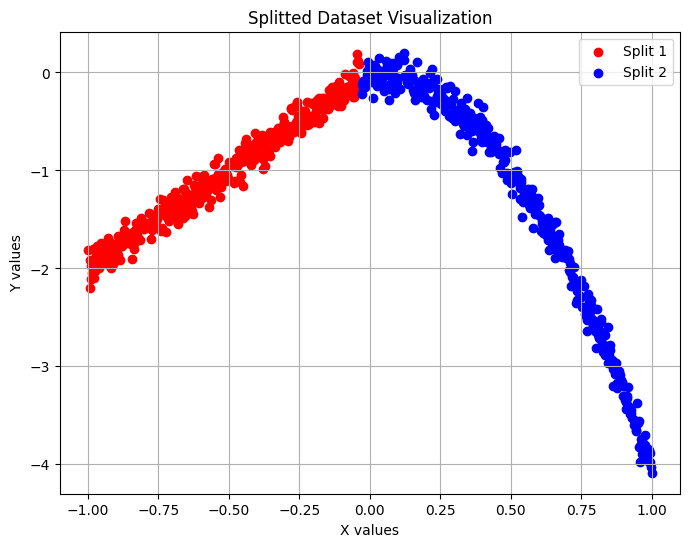

In [ ]:
clients = [
    DenseNetwork(DenseNetwork.Config(1, [12, 12, 12, 12], 1)) for _ in CLIENT_IDs
]

client_optimizer = [
    torch.optim.Adam(clients[client_no].parameters(), lr=0.001)
    for client_no in CLIENT_IDs
]

client_train_dataloaders = data.get_client_test_dataloaders(NUM_CLIENTS, "interval", BATCH_SIZE, shuffle=True)


# Define colors for each split
colors = ['red', 'blue', 'green']

# Plot each subset
plt.figure(figsize=(8, 6))
for i, subset in enumerate(client_train_dataloaders):
    subset = subset.dataset
    x_vals, y_vals = zip(*[subset.dataset[idx] for idx in subset.indices])  # Extract x and y
    plt.scatter(x_vals, y_vals, color=colors[i], label=f"Split {i+1}")

# Add labels and legend
plt.xlabel("X values")
plt.ylabel("Y values")
plt.title("Splitted Dataset Visualization")
plt.legend()
plt.grid()
plt.show()


for client_no in CLIENT_IDs:
    clients[client_no].train()

client_losses = [[] for _ in CLIENT_IDs]

for cr in range(COMMUNICATION_ROUNDS):

    # train each client individually
    for client_no, client in zip(CLIENT_IDs, clients):
        # train each client for certain epochs
        for ce in range(CLIENT_EPOCHS):
            epoch_losses = []
            for x, y in client_train_dataloaders[client_no]:
                client_optimizer[client_no].zero_grad()
                y_hat = client(x)
                loss = loss_fn(y_hat, y)
                epoch_losses.append(loss.item())
                loss.backward()
                client_optimizer[client_no].step()
            client_losses[client_no].append(sum(epoch_losses) / len(epoch_losses))

    # merge the models into a global model
    global_model = fedavg(clients)
    for client in clients:
        client.load_state_dict(global_model.state_dict())

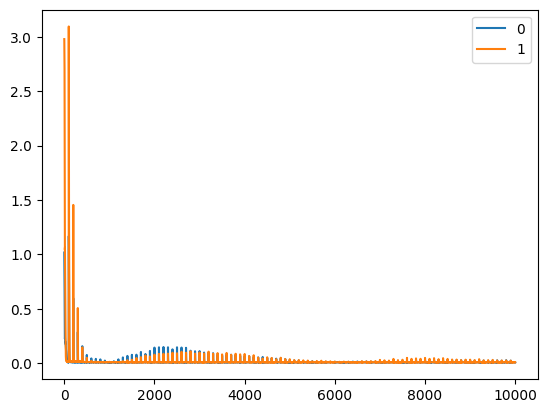

In [ ]:
for client_no, losses in zip(CLIENT_IDs, client_losses):
    plt.plot(losses, label=str(client_no))
plt.legend()
plt.show()

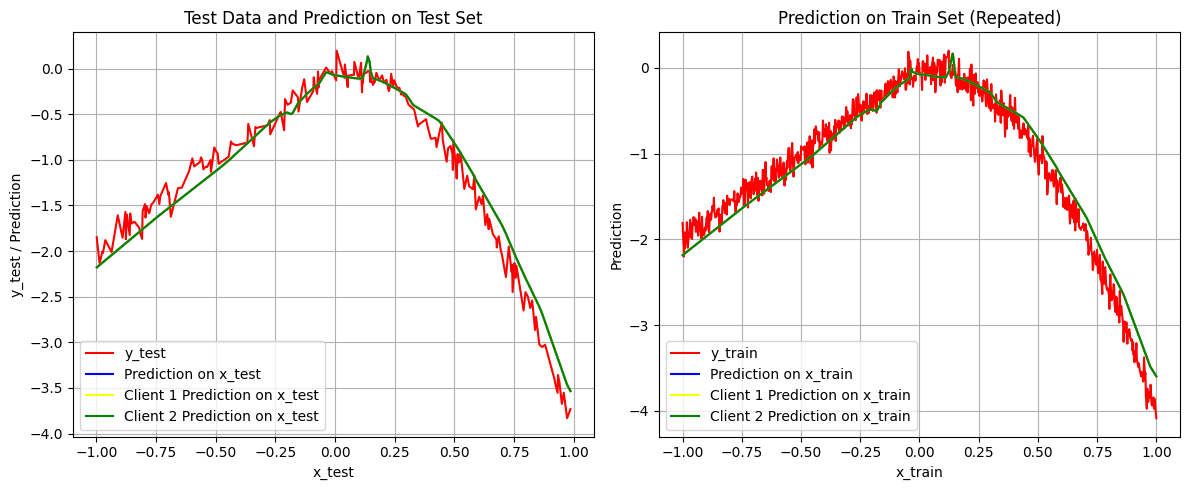

In [31]:
global_model.eval()
for client in clients:
    client.eval()
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

x_test, y_test = data.get_data("test")
x_train, y_train = data.get_data("train")

# First plot (first two lines: y_test and prediction on x_test)
axs[0].plot(x_test, y_test, color="red", label="y_test")  # First line
axs[0].plot(x_test, global_model(x_test.reshape(-1, 1)).detach().numpy(), color="blue", label="Prediction on x_test")  # Second line
axs[0].plot(x_test, clients[0](x_test.reshape(-1, 1)).detach().numpy(), color="yellow", label="Client 1 Prediction on x_test")  # Second line
axs[0].plot(x_test, clients[1](x_test.reshape(-1, 1)).detach().numpy(), color="green", label="Client 2 Prediction on x_test")  # Second line


axs[0].set_title('Test Data and Prediction on Test Set')
axs[0].set_xlabel('x_test')
axs[0].set_ylabel('y_test / Prediction')
axs[0].legend()
axs[0].grid(True)

# Second plot (last two lines: prediction on x_train, repeated)
axs[1].plot(x_train, y_train, color="red", label="y_train")  # First line
axs[1].plot(x_train, global_model(x_train.reshape(-1, 1)).detach().numpy(), color="blue", label="Prediction on x_train")  # Second line
axs[1].plot(x_train, clients[0](x_train.reshape(-1, 1)).detach().numpy(), color="yellow", label="Client 1 Prediction on x_train")  # Second line
axs[1].plot(x_train, clients[1](x_train.reshape(-1, 1)).detach().numpy(), color="green", label="Client 2 Prediction on x_train")  # Second line

axs[1].set_title('Prediction on Train Set (Repeated)')
axs[1].set_xlabel('x_train')
axs[1].set_ylabel('Prediction')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
NUM_CLIENTS = 2
CLIENT_IDs = range(NUM_CLIENTS)

COMMUNICATION_ROUNDS = 10
CLIENT_EPOCHS = 10

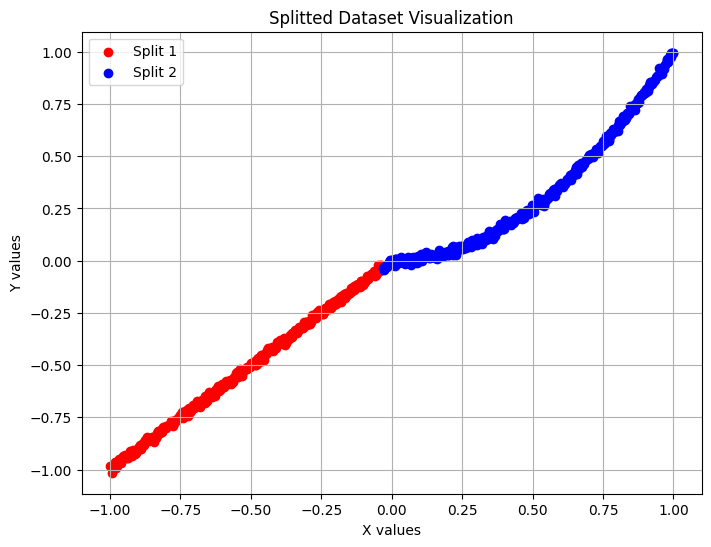

COMUNICATION_ROUND 0
tensor([[181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181.],
        [181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 181., 18

In [ ]:
clients = [SelfLearningNet([12, 12, 12, 12], 1, 1) for _ in CLIENT_IDs]

client_optimizer = [
    torch.optim.Adam(clients[client_no].parameters(), lr=0.001)
    for client_no in CLIENT_IDs
]

client_train_dataloaders = data.get_client_test_dataloaders(NUM_CLIENTS, "interval", BATCH_SIZE, shuffle=True)

# Define colors for each split
colors = ["red", "blue", "green"]


# Plot each subset
plt.figure(figsize=(8, 6))
for i, subset in enumerate(client_train_dataloaders):
    subset = subset.dataset
    x_vals, y_vals = zip(
        *[subset.dataset[idx] for idx in subset.indices]
    )  # Extract x and y
    plt.scatter(x_vals, y_vals, color=colors[i], label=f"Split {i+1}")

# Add labels and legend
plt.xlabel("X values")
plt.ylabel("Y values")
plt.title("Splitted Dataset Visualization")
plt.legend()
plt.grid()
plt.show()


for client_no in CLIENT_IDs:
    clients[client_no].train()

client_losses = [[] for _ in CLIENT_IDs]

for cr in range(COMMUNICATION_ROUNDS):
    print("COMUNICATION_ROUND", cr)

    # train each client individually
    for client_no, client in zip(CLIENT_IDs, clients):
        client_optimizer[client_no] = torch.optim.Adam(
            clients[client_no].parameters(), lr=0.001
        )
        # train each client for certain epochs
        for ce in range(CLIENT_EPOCHS):
            epoch_losses = []
            for x, y in client_train_dataloaders[client_no]:
                client_optimizer[client_no].zero_grad()
                y_hat = client(x)
                loss = loss_fn(y_hat, y)
                epoch_losses.append(loss.item())
                loss.backward()
                client_optimizer[client_no].step()
            client_losses[client_no].append(sum(epoch_losses) / len(epoch_losses))

    # print("Client 1: ", clients[0](x_train.reshape(-1, 1)).reshape(-1))
    # merge the models into a global model

    if cr == COMMUNICATION_ROUNDS - 1:
        print("Last Round Ended")
        global_model = fedavg(clients)
    else:
        global_model = combine(
            clients[0],
            clients[1],
            similarity_threshold_in_degree=1,
            new_weight_initialization="noise",
        )
    # print(global_model.layers)

    last_clients = clients

    clients = [copy.deepcopy(global_model) for _ in CLIENT_IDs]

    # print("GLOBAL: ", global_model(x_train.reshape(-1, 1)).reshape(-1))

    if cr == COMMUNICATION_ROUNDS - 2:
        print("Last Round Coming")
        for client in clients:
            client.freeze_all()
            client.unfreeze_layer(-1)
            client.unfreeze_output_scaling()

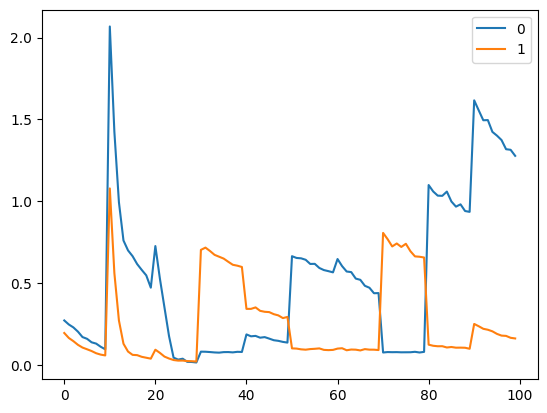

In [ ]:
for client_no, losses in zip(CLIENT_IDs, client_losses):
    plt.plot(losses, label=str(client_no))
plt.legend()
plt.show()

In [17]:
for layer in global_model.layers:
    print(layer.weight.data)

print(global_model.output_scaling.data)

tensor([[-0.7827,  0.6223],
        [ 0.4231,  0.9061],
        [-0.9611, -0.2761],
        [-0.7512,  0.6600],
        [-0.7554, -0.6553],
        [-0.0596, -0.9982],
        [ 0.6247, -0.7809],
        [-0.8519,  0.5237],
        [ 0.4687, -0.8833],
        [-0.8357,  0.5491],
        [ 0.3996,  0.9167],
        [ 0.6548,  0.7558],
        [ 0.8112, -0.5847],
        [-0.3026,  0.9531],
        [-0.9908,  0.1354],
        [-0.6648,  0.7470],
        [ 0.6705, -0.7419],
        [-0.0271, -0.9996],
        [-0.1015,  0.9948],
        [ 0.8689,  0.4949],
        [-0.0456, -0.9990],
        [-0.3823, -0.9240],
        [ 0.9877,  0.1565],
        [-0.1705,  0.9854],
        [ 0.9967, -0.0817],
        [ 0.7459, -0.6661],
        [ 0.8567,  0.5158],
        [-0.1362,  0.9907],
        [-0.6907,  0.7232],
        [ 0.5759, -0.8175],
        [ 0.6459,  0.7635],
        [ 0.4319, -0.9019],
        [ 0.9938,  0.1112],
        [-0.0122, -0.9999],
        [-0.0897, -0.9960],
        [ 0.9905,  0

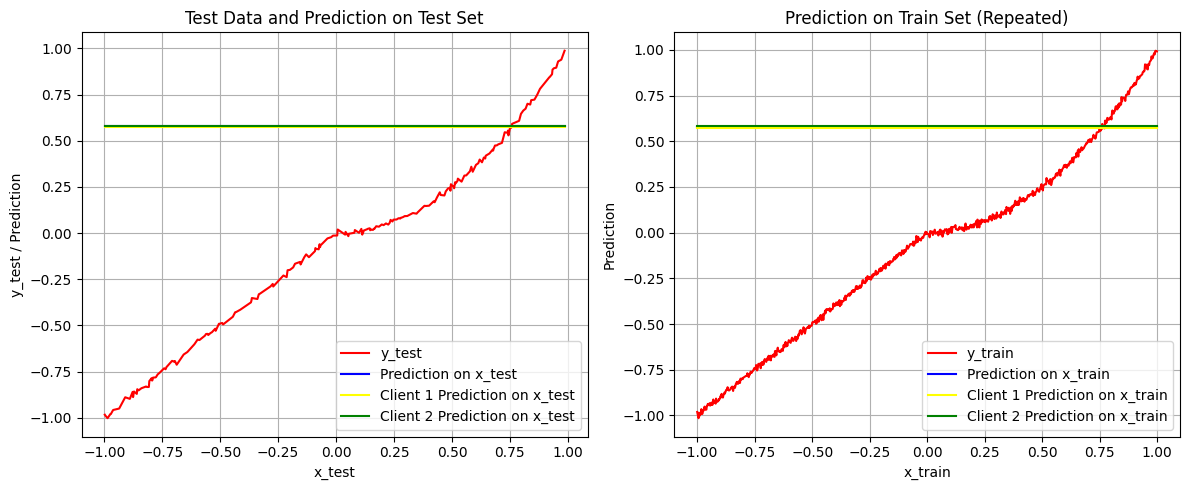

In [18]:
global_model.eval()
for client in clients:
    client.eval()
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First plot (first two lines: y_test and prediction on x_test)
axs[0].plot(x_test, y_test, color="red", label="y_test")  # First line
axs[0].plot(
    x_test,
    global_model(x_test.reshape(-1, 1)).detach().numpy(),
    color="blue",
    label="Prediction on x_test",
)  # Second line
axs[0].plot(
    x_test,
    last_clients[0](x_test.reshape(-1, 1)).detach().numpy(),
    color="yellow",
    label="Client 1 Prediction on x_test",
)  # Second line
axs[0].plot(
    x_test,
    last_clients[1](x_test.reshape(-1, 1)).detach().numpy(),
    color="green",
    label="Client 2 Prediction on x_test",
)  # Second line


axs[0].set_title("Test Data and Prediction on Test Set")
axs[0].set_xlabel("x_test")
axs[0].set_ylabel("y_test / Prediction")
axs[0].legend()
axs[0].grid(True)

# Second plot (last two lines: prediction on x_train, repeated)
axs[1].plot(x_train, y_train, color="red", label="y_train")  # First line
axs[1].plot(
    x_train,
    global_model(x_train.reshape(-1, 1)).detach().numpy(),
    color="blue",
    label="Prediction on x_train",
)  # Second line
axs[1].plot(
    x_train,
    last_clients[0](x_train.reshape(-1, 1)).detach().numpy(),
    color="yellow",
    label="Client 1 Prediction on x_train",
)  # Second line
axs[1].plot(
    x_train,
    last_clients[1](x_train.reshape(-1, 1)).detach().numpy(),
    color="green",
    label="Client 2 Prediction on x_train",
)  # Second line

axs[1].set_title("Prediction on Train Set (Repeated)")
axs[1].set_xlabel("x_train")
axs[1].set_ylabel("Prediction")
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()